In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import librosa as lb
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torchsummary import summary
from torchvision import transforms, datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
# from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

sr = 16000
n_fft = 2048
n_mels = 128
hop_len = 512
fmax = sr//2 #nyquist frq
AUDIO_DIR = "/Volumes/aid_data/buowset/audio"
OUT_DIR = "ImageFolder/train/generated"
file_pattern = os.path.join(AUDIO_DIR, "**", "*.wav")
audio_path = glob.glob(file_pattern, recursive = True)

if not audio_path:
    raise RuntimeError(f"No .wav files found in {AUDIO_DIR}")
path0 = audio_path[2]
y, sr = lb.load(path0,sr = sr)

print(f"Loaded{path0!r}: {y.shape[0]} samples at {sr} Hz")
chunk_dur = 1.0

/Users/haydendosseh/Desktop/autoencoder/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Loaded'/Volumes/aid_data/buowset/audio/3e37cd58-78ec-44a2-8462-6a3bb2615299.wav': 48000 samples at 16000 Hz


In [12]:
def audio_slice (y, chunk_dur, overlap = 0.0, pad = True):
    chunk_size = int(chunk_dur * sr)
    step = int((chunk_dur - overlap) * sr)
    chunks = []
    for i in range(0,len(y), step):
        end = i + chunk_size
        chunk = y[i:end]
        if len(chunk) < chunk_size:
            if pad:
                pad_width = (0, chunk_size - len(chunk))
                chunk = np.pad(chunk, pad_width, mode = 'constant')
        elif len(chunk) < chunk_size * 0.5:
            break
        chunks.append(chunk)
    return np.array(chunks)

chunks = audio_slice(y, chunk_dur=1.0)
print(f"Created {len(chunks)} chunks of shape {chunks.shape[0]}")

Created 3 chunks of shape 3


In [4]:
def log_mel (chunks, sr, n_mels, n_fft, hop_len, fmax):
    log_melspecs = []
    for chunk in chunks:
        mel_spec = lb.feature.melspectrogram (
            y = chunk,
            sr = sr,
            n_fft = n_fft,
            hop_length = hop_len,
            n_mels = n_mels,
            fmax = fmax 
        )
        log_melspec = lb.power_to_db(mel_spec, ref = np.max)
        log_melspecs.append(log_melspec)
    return np.array(log_melspecs)

mel_spec = log_mel(chunks, sr, n_mels, n_fft, hop_len, fmax)

big_mel_spec = np.hstack(mel_spec)

In [5]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import os

i = 0
while i < 6:
    path0 = audio_path[i]
    y, sr = lb.load(path0, sr=sr)
    chunks = audio_slice(y, chunk_dur=1.0)
    mel_spec = log_mel(chunks, sr, n_mels, n_fft, hop_len, fmax)
    
    big_mel_spec = np.hstack(mel_spec)
    
    # Create figure without axes/labels for clean image
    fig = plt.figure(figsize=(10, 4), frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])  # Full figure, no margins
    ax.set_axis_off()
    fig.add_axes(ax)
    
    # Plot spectrogram
    librosa.display.specshow(
        big_mel_spec,
        sr=sr,
        hop_length=hop_len,
        x_axis=None,  # Remove axis labels
        y_axis=None,
        fmax=fmax,
        ax=ax
    )
    
    out_path = os.path.join(OUT_DIR, f"mel_spec_{i:02d}.png")
    plt.savefig(out_path, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()  # Important: close to free memory
    i += 1

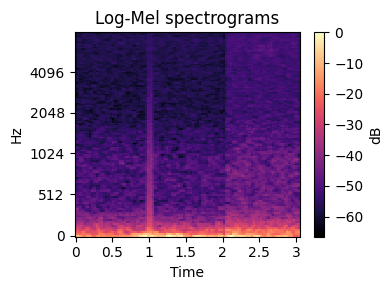

In [6]:
plt.figure(figsize = (4,3))
lb.display.specshow(
    big_mel_spec,
    sr = sr,
    hop_length = hop_len,
    x_axis = "time",
    y_axis = "mel",
    fmax = fmax
)
plt.colorbar(label = "dB")
plt.title("Log-Mel spectrograms")
plt.tight_layout()
plt.show()

""" Audio data is loaded from burrowing owl dataset on the NAS
 - The wav file is sliced into 1s chunks
 - Log-mel spectrograms are generated from the 1s chunks
 - The chunks are cocatenated into 1 mel spectrogram and plotted as a png file"""


In [6]:
data_transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.ImageFolder(root='./ImageFolder/train', transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

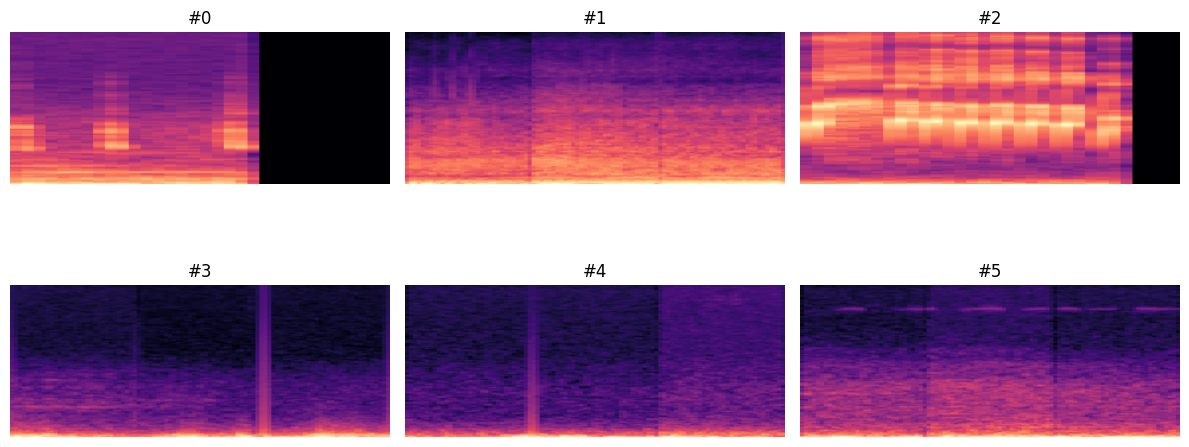

In [7]:


# 1) decide how many rows & cols you want...
nrows, ncols = 2, 3
n_images = nrows * ncols

# 2) build a DataLoader that will give you at least that many
loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = n_images,
    shuffle    = True,
    num_workers= 4,
)

# 3) grab exactly one batch
first_batch, _ = next(iter(loader))   # first_batch.shape == (n_images, C, H, W)

# 4) turn that into a H×W×C NumPy array for plt.imshow
imgs = first_batch.permute(0,2,3,1).cpu().numpy()  
#         ^-- now shape is (n_images, H, W, C)

# 5) plot in a neat grid
#fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3))

plt.figure(figsize=(12,6))
for idx in range(0,6):
    plt.subplot(2, 3, idx+1)
    plt.imshow(imgs[idx])   # each imgs[idx] is an H×W×3 RGB image
    plt.axis("off")
    plt.title(f"#{idx}")

plt.tight_layout()
plt.show()


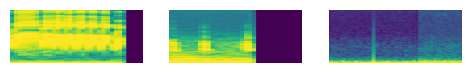

In [8]:
%matplotlib inline
first_batch, _ = next(iter(dataset_loader))  # retrieve the first batch
fig = plt.figure(figsize=(12, 6))
for row in range(1,2):  # show 3 rows
    for col in range(1, 4):  # show 3 columns
        index = 6 * (row - 1) + col
        image = first_batch[index - 1, 0, :]  # retrieve images as (28, 28) tensors
        #print image.shape
        fig.add_subplot(3, 6, index)
        #index = torch.LongTensor([1,2,0])
        #image[index]=image
        plt.imshow(image.numpy())

        plt.axis('off')
plt.show()

In [9]:

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        #conv 1
        self.cnn1=nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=2)
        self.relu1=nn.ReLU()

        #Maxpool 1
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        #conv 2
        self.cnn2=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=2)
        self.relu2=nn.ReLU()

        #Maxpool 2
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        #conv1
        out=self.cnn1(x)
        out=self.relu1(out)
        
        #max poo1 1
        out=self.maxpool1(out)
       
        #conv2
        out=self.cnn2(out)
        out=self.relu2(out)
        
        #max poo1 2
        out=self.maxpool2(out)
        #print out.shape
        return out

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.DCV1 = nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=4, stride=1, padding=2)
        self.relu1=nn.ReLU()
        self.DCV2 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.relu2=nn.ReLU()
        self.DCV3 = nn.ConvTranspose2d(64, 3, 4, 2, 1)
        

    def forward(self, x):
        out = self.DCV1(x)
        out = self.relu1(out)
        out = self.DCV2(out)
        out = self.relu2(out)
        out = self.DCV3(out)
        out = torch.sigmoid(out)
        return out


In [10]:
    
encoder = Encoder()
decoder = Decoder()

criterion = nn.MSELoss()
params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.002)

In [11]:
train_losses = []
val_losses = []
epochs = 50

for epoch in range(epochs):
    # TRAINING PHASE
    encoder.train()
    decoder.train()
    epoch_train_loss = 0
    num_train_batches = 0
    
    for i, (images, labels) in enumerate(dataset_loader):
        images = Variable(images)
        
        optimizer.zero_grad()
        outputs = encoder(images)
        outputs = decoder(outputs)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        num_train_batches += 1
        
        if (i) % 100 == 0:
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
                  %(epoch+1, epochs, i+1, len(dataset_loader), loss.item()))
    
    # Calculate average training loss for this epoch
    avg_train_loss = epoch_train_loss / num_train_batches
    train_losses.append(avg_train_loss)
    
    # VALIDATION PHASE
    encoder.eval()
    decoder.eval()
    epoch_val_loss = 0  # Initialize this variable!
    num_val_batches = 0
    
    with torch.no_grad():
        for images, labels in dataset_loader:  # Same dataset for now
            images = Variable(images)
            outputs = encoder(images)
            outputs = decoder(outputs)
            val_loss = criterion(outputs, images)
            epoch_val_loss += val_loss.item()
            num_val_batches += 1
    
    # Calculate average validation loss for this epoch
    avg_val_loss = epoch_val_loss / num_val_batches
    val_losses.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Now plot both losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch [1/50], Iter [1/1] Loss: 0.1001
Epoch [1/50] Train Loss: 0.1001, Val Loss: 0.0943
Epoch [2/50], Iter [1/1] Loss: 0.0943
Epoch [2/50] Train Loss: 0.0943, Val Loss: 0.0820
Epoch [3/50], Iter [1/1] Loss: 0.0820
Epoch [3/50] Train Loss: 0.0820, Val Loss: 0.0775
Epoch [4/50], Iter [1/1] Loss: 0.0775
Epoch [4/50] Train Loss: 0.0775, Val Loss: 0.0703
Epoch [5/50], Iter [1/1] Loss: 0.0703
Epoch [5/50] Train Loss: 0.0703, Val Loss: 0.0665
Epoch [6/50], Iter [1/1] Loss: 0.0665
Epoch [6/50] Train Loss: 0.0665, Val Loss: 0.0636
Epoch [7/50], Iter [1/1] Loss: 0.0636
Epoch [7/50] Train Loss: 0.0636, Val Loss: 0.0584
Epoch [8/50], Iter [1/1] Loss: 0.0584
Epoch [8/50] Train Loss: 0.0584, Val Loss: 0.0504
Epoch [9/50], Iter [1/1] Loss: 0.0504
Epoch [9/50] Train Loss: 0.0504, Val Loss: 0.0404
Epoch [10/50], Iter [1/1] Loss: 0.0404
Epoch [10/50] Train Loss: 0.0404, Val Loss: 0.0324
Epoch [11/50], Iter [1/1] Loss: 0.0324
Epoch [11/50] Train Loss: 0.0324, Val Loss: 0.0273
Epoch [12/50], Iter [1/1] Lo

KeyboardInterrupt: 

Python(18924) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18925) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18926) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18927) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


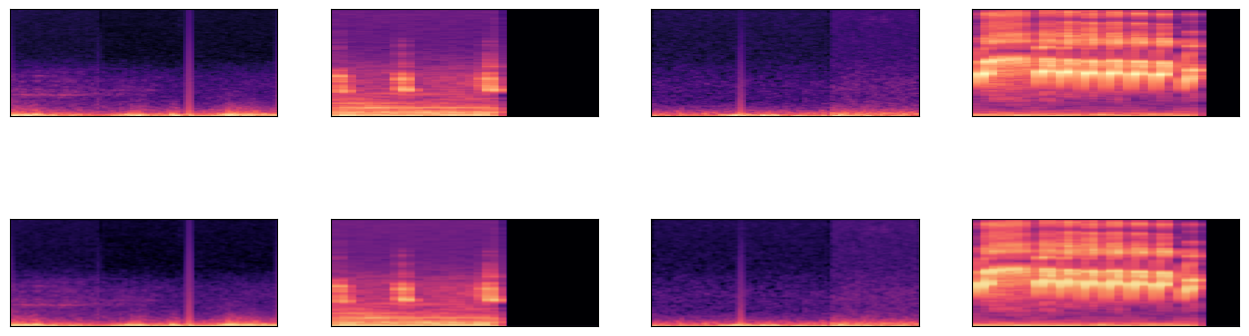

In [13]:
encoder.eval()
decoder.eval()

# total images to display
n = 5
plt.figure(figsize=(20,5))

for images, labels in dataset_loader:
    
    images = Variable(images)
    outputs = encoder(images)
    outputs = decoder(outputs)
    count = 0
    
    in_out = zip(images, outputs)
    for image, output in in_out:
        count += 1
        if count >= n:
            break
            
        # display original images    
        ax = plt.subplot(2, n, count )
        #print output.shape
        plt.imshow(image.data.numpy().transpose(1,2,0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display reconstruction
        ax = plt.subplot(2, n, count + n)
        #print output.shape
        plt.imshow(output.data.numpy().transpose(1,2,0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)   
            
    break

In [14]:
torch.save(encoder.state_dict(), 'encoder.pkl')
torch.save(decoder.state_dict(), 'decoder.pkl')

In [15]:
reconstruction_loss = nn.MSELoss()

In [1]:
encoder.eval()
decoder.eval()
test_loss = 0
for data, _ in dataset_loader:

    data = Variable(data, volatile=True)
    out = encoder(data)
    out = decoder(out)
    test_loss += reconstruction_loss(out, data).item()
test_loss /= len(dataset_loader.dataset)
print('====> Test set loss', test_loss)

NameError: name 'encoder' is not defined

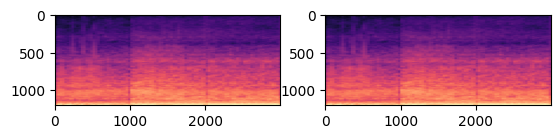

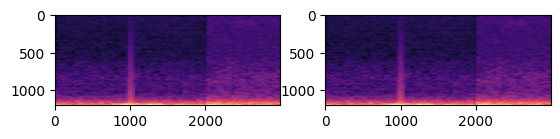

In [16]:
t1,y = train_dataset[0]
ax = plt.subplot(2, 2, 1)
plt.imshow(t1.numpy().transpose(1,2,0))
ax = plt.subplot(2, 2, 2)
at1=t1
plt.imshow((at1.numpy()).transpose(1,2,0))
plt.show()

t2,y = train_dataset[5]
bx = plt.subplot(2, 2, 1)
plt.imshow(t2.numpy().transpose(1,2,0))
bx = plt.subplot(2, 2, 2)
at2=t2
plt.imshow((at2.numpy()).transpose(1,2,0))
plt.show()

In [17]:
plt.figure(figsize=(50,5))
def evaluate(inp,ori):
    images = inp.unsqueeze(0)
    images = Variable(images)
    outputs = encoder(images)
    outputs = decoder(outputs)
    #print images.shape
    #print outputs.shape
    # display noisy images    
    # ax = plt.subplot(2, 3, 1)
    # #print output.shape
    # plt.imshow(images.squeeze(0).data.numpy().transpose(1,2,0))
    # plt.gray()
    # plt.title('noisy image')

    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, 3, 1)
    #print output.shape
    plt.imshow(outputs.squeeze(0).data.numpy().transpose(1,2,0))
    plt.gray()
    plt.title('reconstructed image')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False) 
    
    # display ori images    
    ax = plt.subplot(2, 3, 2)
    #print output.shape
    plt.imshow(ori.squeeze(0).numpy().transpose(1,2,0))
    plt.gray()
    plt.title('original image')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.show()
    print ('reconstruction loss : %f '%(reconstruction_loss(Variable(ori), images).item()))

<Figure size 5000x500 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.525122..0.9997714].


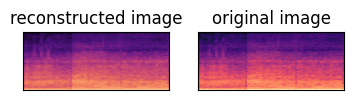

/Users/haydendosseh/Desktop/autoencoder/venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1, 3, 1200, 3000])) that is different to the input size (torch.Size([3, 1200, 3000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


reconstruction loss : 0.000000 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5244986..0.99974906].


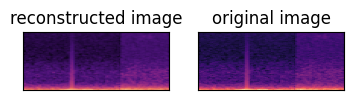

reconstruction loss : 0.000000 


In [18]:
evaluate(at1,t1)
evaluate(at2,t2)

In [ ]:
# Extract latent vectors for a batch of images
encoder.eval()
latent_vectors = []
original_images = []

with torch.no_grad():
    for images, labels in dataset_loader:
        images = Variable(images)
        latent = encoder(images)
        
        latent_vectors.append(latent.cpu().numpy())
        original_images.append(images.cpu().numpy())
        
        if len(latent_vectors) >= 5:  # Collect a few batches
            break

latent_vectors = np.concatenate(latent_vectors, axis=0)
original_images = np.concatenate(original_images, axis=0)

print(f"Latent space shape: {latent_vectors.shape}")
print(f"Original images shape: {original_images.shape}")

ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

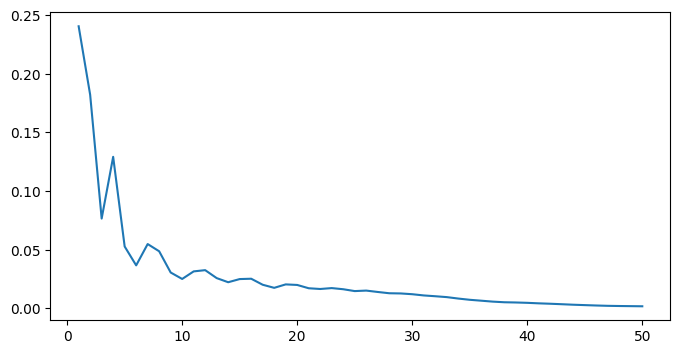

In [19]:
import matplotlib.pyplot as plt

# Example loss histories; replace with your actual values
# train_losses = [0.9, 0.7, 0.5, 0.4]
# val_losses   = [1.0, 0.8, 0.6, 0.55]

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss,   label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

"""Conv-AE based on work by Mani Shankar (https://github.com/manishankarbalu/ConvAE/commits?author=manishankarbalu)
- Mel spectrogram png are encoded and decoded
- The resulting loss is plotted
TODO; - Encode and decode wav files directly
    - Plot resulting loss and compare with Codec2"""